# Imports

In [74]:
import yfinance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
from mmar import *
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'arial'

import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", message=".*RANSAC did not reach consensus.*", category=RuntimeWarning)

# Import Data

In [5]:
ticker_symbol = 'CL=F'
start_date = '1990-01-01'
end_date = '2023-08-24'
data = yf.download(ticker_symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [6]:
prices = data['Adj Close']
prices_fixed = prices.copy()

In [7]:
prices.describe()

count    5774.000000
mean       63.922347
std        25.560900
min       -37.630001
25%        44.610001
50%        61.650000
75%        83.267498
max       145.289993
Name: Adj Close, dtype: float64

<AxesSubplot:xlabel='Date'>

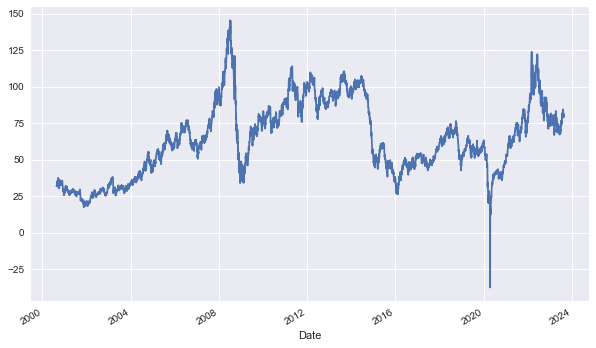

In [8]:
plt.figure(figsize=(10, 6))
prices.plot()

# FBM Simulation and Monte Carlo Option Prcing

Fractional Brownian Motion can be described as a "walk" where the next step might be influenced by previous steps. 

This could be for example in the form of momentum or reversion. This introduction of "memory" via the hurst exponent aims to model this well-known memory feature of financial markets. FBM is compontent of the MMAR that will be described in the following sections.

## Calculate the Hurst component of Crude oil data

The Hurst exponent \(H\) is a statistical measure used to classify time series data. It can help in determining the nature of a given time series:

- \(H < 0.5\): The time series has a tendency to revert to a mean (negative autocorrelation).
- \(H = 0.5\): The time series follows a random walk (Brownian motion).
- \(H > 0.5\): The time series shows a persistent behavior (positive autocorrelation).

However, different lenghts of timeseries could generate different values of Hurst Exponent. This is due to the fact that the same underlying process (i.e. the positive or negative autocorrelation present in the timeseries) can appear differently under different sampling sizes or resolutions. 

One solution is the one proposed below, where the price data is divided into segments and several calculations of H generating a distribution. 

In [9]:
num_segments = 625
hurst_values = calculate_hurst_for_segments(prices, num_segments)

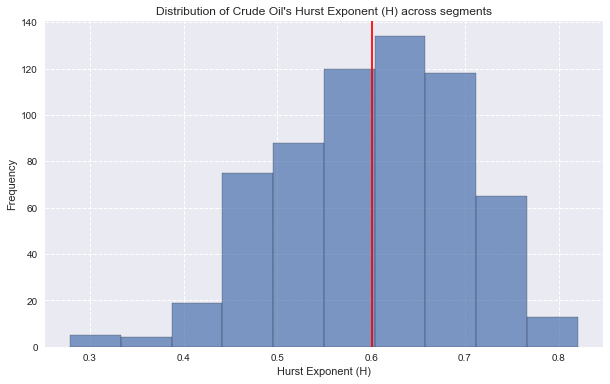

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(hurst_values, bins=10, edgecolor='black', alpha=0.7)
plt.title("Distribution of Crude Oil's Hurst Exponent (H) across segments")
plt.xlabel("Hurst Exponent (H)")
plt.ylabel("Frequency")
plt.axvline(np.mean(hurst_values), color='red')
plt.grid(True, which="both", ls="--")
# plt.savefig('dist_oil_h.png')
plt.show()

In [11]:
np.mean(hurst_values)

0.6006649377238248

In [12]:
h_oil = np.mean(hurst_values)

Crude Oil's Hurst Exponenet is seen centered around 0.60, i.e small persistence autocorrelation.

In [13]:
fbm_oil = nolds.fbm(100, H=h_oil)
fbm_oil = pd.Series(fbm_oil)

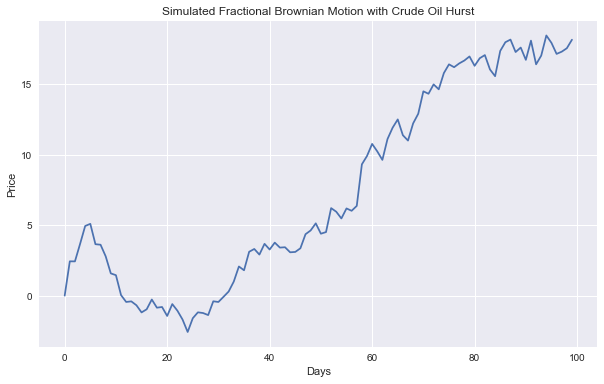

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(fbm_oil)
#plt.axhline(y=0.0, color='grey', linestyle='-.', linewidth=1)
plt.title('Simulated Fractional Brownian Motion with Crude Oil Hurst')
# plt.legend(loc=0)
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

We can see from the above simulation that for any realistic simulation of prices using a FBM, we could include a limitation for prices going negative (even though oil prices did go negative in the past!).

To examplify the process of pricing an option using Monte Carlo simulation from a given stochastic model, we will attempt to price an European call option under the assumption that the price of the asset follows a fractional Brownian Motion process (fbm). We will later use the same methodology to calculate the payoff and discounted value for the MMAR simulations:

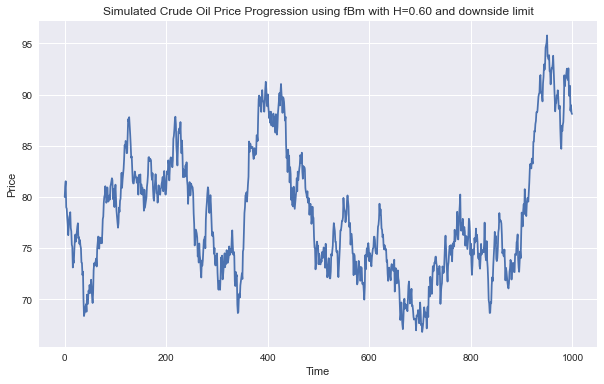

In [15]:
def generate_fbm_path(n, hurst, dt=1, s0=1):
    """Generate a fractional Brownian motion path with n steps and a given Hurst exponent."""
    # Generate Gaussian Noise using numpy's random.randn
    dW = np.random.randn(n)
    
    # Generate the fBm increments (scales with time as per Hurst exponent)
    increments = dW * (dt**(hurst))
    
    # Construct the fBm path
    fbm_path = np.cumsum(increments)
    
    # Shift the path to start at s0
    fbm_path = fbm_path - fbm_path[0] + s0
    
    return fbm_path

n = 1000  # number of steps
hurst_mean = h_oil  # Mean Hurst value calculated from earlier
prices = generate_fbm_path(n, hurst_mean, s0=80)

# Imposing floor to ensure prices don't go below 0
prices = np.where(prices > 0, prices, 0)

# Plot the simulated prices
plt.figure(figsize=(10, 6))
plt.plot(prices)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'Simulated Crude Oil Price Progression using fBm with H={hurst_mean:.2f} and downside limit')
plt.grid(True)
#plt.savefig('oil_fbm_downside_s0.png')
plt.show()

The simulation above we introduced s0 = 80 (where crude oil is roughly trading currently) and a downside limitation to prices.  

## Pricing Oil Options with FBM and  Monte Carlo

In [82]:
num_paths = 1000 
n = 252  # Number of steps per path, Assuming daily steps for a year
hurst_mean = h_oil  # Mean Hurst value calculated from earlier
s0 = 80  # Starting price
r = 0.05
T = 1
K = 80  # Strike price

In [17]:
def generate_multiple_paths(num_paths, n, hurst, dt=1, s0=1):
    """Generate multiple fBm paths"""
    paths = []
    # For each path
    for _ in range(num_paths):
        prices = generate_fbm_path(n, hurst, dt, s0)
        # Imposing floor to ensure prices don't go below 0
        prices = np.where(prices > 0, prices, 0)
        paths.append(prices)
    
    return paths

In [84]:
paths = generate_multiple_paths(num_paths, n, hurst_mean, s0=s0)
call_price = option_pricer(paths, strike=K, r=r, T=T, option_type='call')
put_price = option_pricer(paths, strike=K, r=r, T=T, option_type='put')

print(f"European Call Option Price (Strike {K}): ${call_price:.2f}")
print(f"European Put Option Price (Strike {K}): ${put_price:.2f}")

European Call Option Price (Strike 80): $6.23
European Put Option Price (Strike 80): $6.52


We can see from the implied option prices in the market for the 1year ATM call option price for WTI is currently at $8.8 accordinging to the Bloomberg information which is using Black Scholes Model.
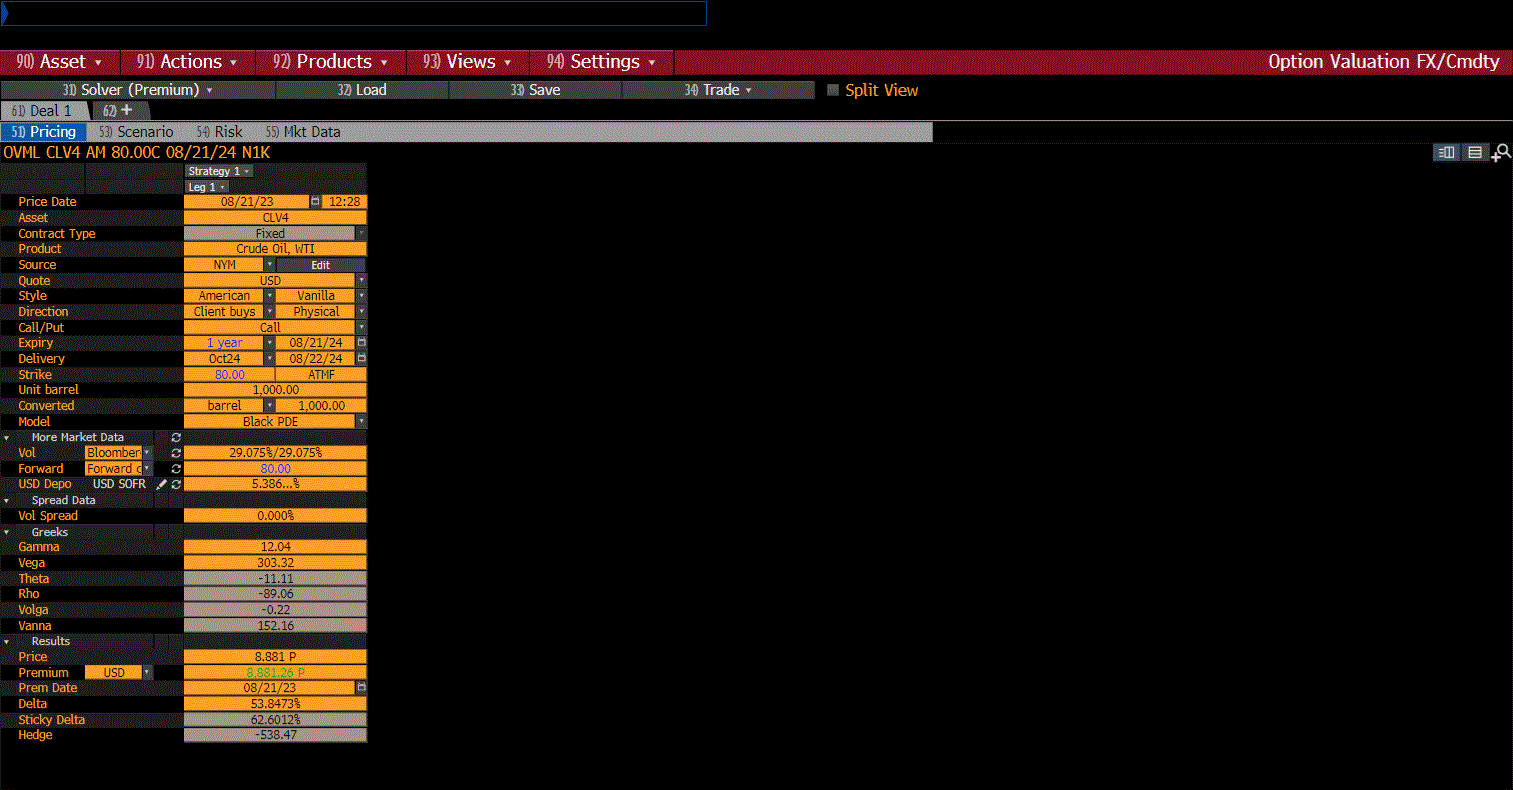
This model is underpricing the option relatively to the market.

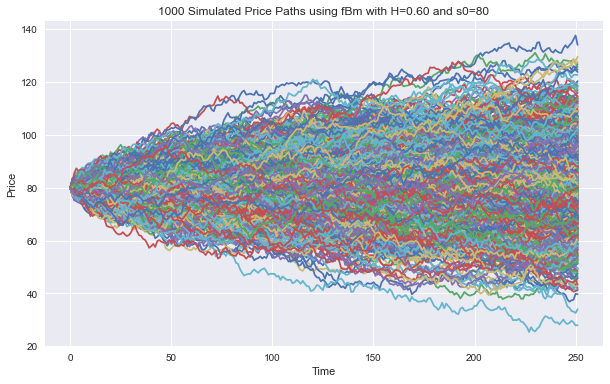

In [19]:

plt.figure(figsize=(10, 6))
for path in paths:
    plt.plot(path)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{num_paths} Simulated Price Paths using fBm with H={h_oil:.2f} and s0={s0}')
plt.grid(True)
plt.show()

# The Multifractal Model of Asset Returns

## The Multiplicative Cascade Process

A vital part of the Multifractal Model of Asset Returns (MMAR) is the multiplicative cascade process, which produces the multifractal measure. This process can be illustrated mathematically as:

$$ \theta(t) = \prod_{i=1}^{k} x_i $$

Here, each \( $x_i$ \) is an independent and identically distributed random variable, and \( k \) represents the number of steps in the cascade process. The exact distribution of \( $x_i$ \) will be contingent on the specific traits of the financial time series under analysis.

Another distinguishing attribute of the MMAR is its capability to simulate several statistical properties observed in financial returns, such as heavy tails and volatility clustering. These characteristics can be embodied by the autocorrelation function of the absolute returns, which can be estimated as:

$$ Corr(|r_t|, |r_{t+\tau}|) \approx C \tau^{2H-2} $$

In this equation, \( C \) is a constant, \( $\tau$ \) is the time lag, and \( H \) is the Hurst exponent.

Put simply, the multiplicative cascade is a process where at each stage of the cascade (subdivision or step), a given quantity is multiplied by a factor to produce the quantities for the next layer. The process is an iterative one, creating a hierarchy or cascade of multiplications. In the context of fractals, the Multiplicative Cascade helps to produce a measure that shows multifractal properties. This is because different parts of the data will have different scaling behaviors in result of the cascade multiplication which creates a complex and multifractal structure. 

## MMAR Model Simulations

The steps to calculate the fractal parameters are as follows:

1. Get daily price data of WTI and calculate the log return of the prices
2. Generate the statistical moments $q$ that will be used for the partition function. 
3. Define the suitable time window $dt$ 
4. Calculate the partition values $Fq(dt, q)$ for different values of $dt$ and $q$,
5. Calculate the scaling exponent $\tau_q$ (the regressions of the partition values). 
6. Calculate the Hurst component $H$
7. Calculate the Multifractal Spectrum f(α).
8. Calculate Hölder exponent $\alpha_0$. 
9. Calculate $\lambda$ and $\sigma^2$ for the log-normal distribution parameters. 
10. Determine the number of data points to simulate. 
11. Generate a log-normal multiplicative cascade. 
12. Calculate the trading time function $\theta(t)$. 
13. Simulate a Fractional Brownian Motion with the estimated parameters. 
14. Simulate the MMAR returns and prices.
15. Calculate the instinct value of options

#### 1. Get daily price data of WTI and calculate the log return of the prices

In [21]:
close_return = prices_fixed.copy()
close_return.loc[close_return < 0] = 0.0001
close_return = np.log(close_return/close_return.shift())
close_return = close_return.dropna()

#### 2. Generate the statistical moments $q$ that will be used for the partition function. 

In [22]:
# Define the sequence ranges
# Select the values of q

power = 3 # up to a value with a quadratic shape produced below
q = np.linspace(0.01, 3, 120)
q[:10]

array([0.01      , 0.03512605, 0.0602521 , 0.08537815, 0.1105042 ,
       0.13563025, 0.1607563 , 0.18588235, 0.2110084 , 0.23613445])

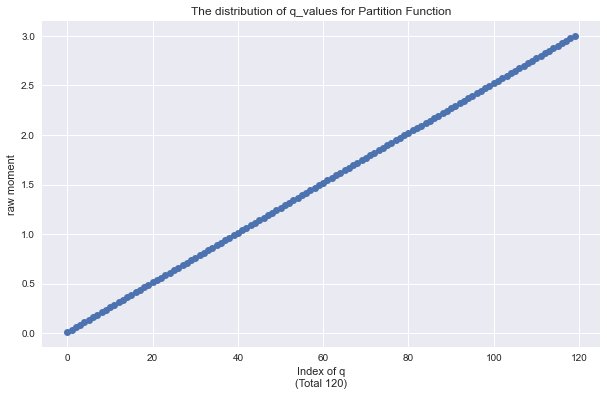

In [23]:
# Plotting q_values
plt.figure(figsize=(10,6))
plt.grid(True)
plt.title("The distribution of q_values for Partition Function")
plt.xlabel(f"Index of q\n(Total {len(q)})")
plt.ylabel('raw moment')
plt.plot(q, marker='o')
# plt.savefig('dist_q_values.png')
plt.show()

#### 3. Define the suitable time window $dt$ 

In [24]:
min_window = 10
max_window = len(prices_fixed)
print('length of the training prices data: ', len(prices_fixed))

window_sizes = define_time_window(min_window=min_window, max_window=max_window, base=10, interval=0.25)
window_sizes

length of the training prices data:  5774


[10, 17, 31, 56, 100, 177, 316, 562, 1000, 1778, 3162, 5623]

#### 4. Calculate the partition values $Fq(dt, q)$ for different values of $dt$ and $q$ and 5. Calculate the scaling exponent $\tau_q$ (the regressions of the partition values). 

In summary, the Chhabra-Jensen method uses the partition function to characterize scaling behavior and then Legendre transforms this to derive the multifractal spectrum.

In [25]:
Fq, tau_q_list = calculate_scaling_exponent(window_sizes, prices_fixed, q)

calculating q=0 out of 119
calculating q=30 out of 119
calculating q=60 out of 119
calculating q=90 out of 119
Finished calculating the partition values Fq


In [26]:
Fq.head()

,10,17,31,56,100,177,316,562,1000,1778,3162,5623
0.010000,581.247033,342.564498,188.482636,104.605661,57.987579,32.738237,18.457816,10.262990,5.123352,3.039287,1.042018,1.039347
0.035126,592.373963,351.866004,194.975997,108.820573,60.590000,34.700358,19.670754,10.962584,5.457136,3.147290,1.155550,1.145178
0.060252,604.167835,361.678171,201.849047,113.306125,63.374061,36.825551,20.979208,11.721509,5.827548,3.269415,1.281453,1.261786
0.085378,616.648673,372.023029,209.120655,118.078894,66.351217,39.126845,22.391131,12.544898,6.238002,3.406792,1.421072,1.390267
0.110504,629.838247,382.924119,216.811051,123.156809,69.533949,41.618453,23.915175,13.438341,6.692271,3.560675,1.575904,1.531831


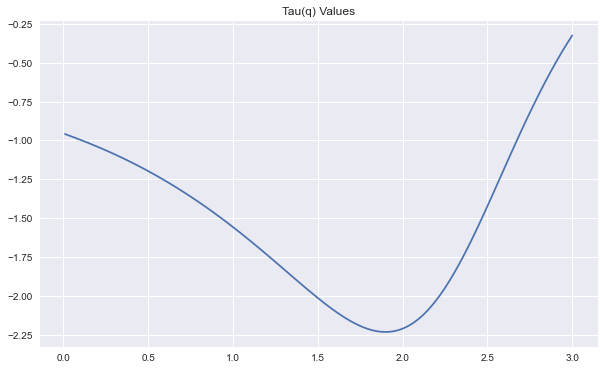

In [27]:
# plot τ(q) with q
# Monofractal signals show a linear τ(q) curve. The slope gives the single Hurst exponent H.
# Multifractal τ(q) curves are nonlinear. The curvature reveals richer structure.
# If the graph is not showing quadratic shape, the power used to produce q values may need to refine
plt.figure(figsize=(10, 6))
y = np.array(Fq.index)
plt.plot(y, tau_q_list)
plt.title('Tau(q) Values')
# plt.savefig('tau_values.png')
plt.show()

#### 6. Calculate the Hurst component $H$

We have calculate in the previous session so we just refer back to the calculated value

In [28]:
H = h_oil
H

0.6006649377238248

#### 7. Calculate the Multifractal Spectrum f(α)

- Legendre transform τ(q) to get f(α) Multifractal spectrum:
- By scanning over different values of q, we can trace out the multifractal spectrum f(α).

In [29]:
F_A, parameters_of_spectrum = estimate_multifractal_spectrum(tau_q_list, q, 0, len(q)-1)

Using the range of q's from 0.01 to 3.0:
The estimated parameters for tau(q) are: 
[ 0.6648871  -2.03791286 -0.46099998]

Thus, the estimated parameters for f(a) are: 
 width_of_spectrum: 0.37600368754200564, 
 holder_exponent: 1.5325255028402258, 
 asymmetry_of_spectrum: 2.0225766993445533


#### 8. Finding the most probable Hölder exponent.

- The width of f(α) indicates degree of multifractality. α_min and α_max give range of Hölder exponents.

- The α at max f(α) gives the most probable Hölder exponent α0

- α0 = a for max[f(α)]

- Sibirtsev concludes, “The interpretation for α0 is this: if the data is multifractal —
meaning that it can have different Hölder exponents at different timepoints — then
α0 is the most commonly occurring, most “dominant” Hölder exponent in the price
data.”

The Hölder exponent indicates the local regularity or "smoothness" of a signal at a given point. It quantifies the scaling behavior and singularity strength. The Hölder exponent α measures how fast the signal is oscillating or changing as you zoom in.  

Larger exponent just implies higher order differentiability and smoothness in the signal's dynamics. The magnitude quantifies exactly how stable and noise-free it looks at finer scales.

In [30]:
# from the result above the
a0 = parameters_of_spectrum[1]
a0

1.5325255028402258

#### 9. Calculate $\lambda$ and $\sigma^2$ for the log-normal distribution parameters.

In [31]:
# λ = α0 / H
simulated_lambda = a0 / H
print(simulated_lambda)

# σ2 = 2(λ — 1) / ln[b]
simulated_variance = 2*(simulated_lambda - 1) / np.log(2)
simulated_sigma = np.sqrt(simulated_variance)
print(simulated_sigma)

2.5513816548833654
2.1157365715165697


#### 10. Determine the number of data points to simulate. 

Here we are considering in using the binomial cascade, meaning that each interval is split into two each time (meaning b=2)

The simulation takes b*k data points. Therefore it is best to select b and k close to the desired number of data points. For example, if we want to simulate one year 252 data points. When b = 2 and k = 8, we gets 256 simulated data points to cover our need

In [106]:
# find the k when b == 2
days_for_simulation = 252
K = math.ceil(np.log2(days_for_simulation)) # k value
display(K)
display(2**K)

8

256

#### 11. Generate a log-normal multiplicative cascade.

In summary, the function implements the theoretical lognormal cascade by recursively splitting, weighting, and branching the value v at each step.

At each step, it splits the value v into two parts, multiplies each by a random lognormal weight, and recursively cascades those parts. This matches the theoretical description of a multiplicative lognormal cascade:

- Splitting into two parts (b=2)
- Multiplying by random lognormal weights
- Cascading recursively in a branching way

In [100]:
new_cascade = calculate_lognormal_cascade(layers=K, v=1, ln_lambda = np.log(simulated_lambda), ln_sigma = np.log(simulated_sigma))
new_cascade = list(np.array(new_cascade).flat)

#### 12. Calculate the trading time function 

In [101]:
trading_time = calculate_trading_time(layers=K, lognormal_cascade=new_cascade)
trading_time = trading_time[:252] # Only get the subset for the simulation

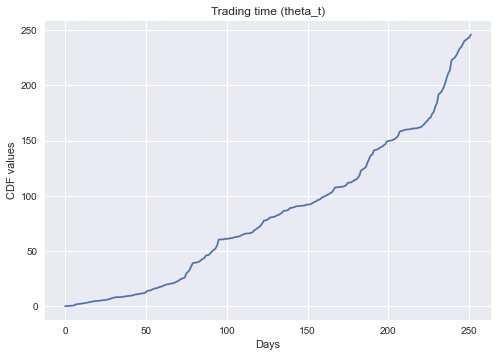

In [102]:
plt.plot(trading_time)
plt.title('Trading time (theta_t)')
plt.xlabel('Days')
plt.ylabel('CDF values')
plt.grid(True)
plt.show()

#### 13. Simulate a Fractional Brownian Motion with the estimated parameters. 

We need to find the suitable magnitude_parameter by adjust the fBm “length” for the market until the median standard deviation of returns was approximately the same as that of the real data

In [107]:
%%time
magnitude_parameter = calculate_magnitude_parameter(initial_value=0.5, eps=0.01, steps=0.5, number_of_path=100, real_std=np.std(close_return), layers=K, hurst_exponent=h_oil)

Diff:  0.01212495231450958
new magnitude_parameter: 0.5060624761572547
Diff:  -0.004425647450309461
CPU times: total: 10.3 s
Wall time: 10.6 s


#### 14. Simulate the MMAR returns and prices.


In [128]:
number_of_path = 1000
s0 = 80  # Starting price

mmar_returns, prices_paths = calculate_mmar_returns(S0=s0, number_of_path=number_of_path, layers=K, hurst_exponent=h_oil, trading_time=trading_time, magnitude_parameter=magnitude_parameter)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:53<00:00, 18.69it/s]


In [129]:
def plot_mmar_paths(paths, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    
    for path in paths:
        plt.plot(path)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

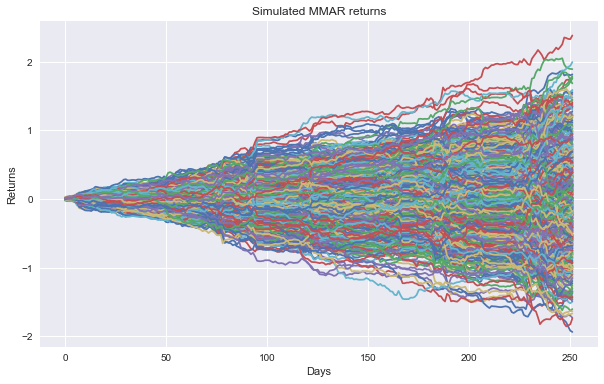

In [130]:
plot_mmar_paths(mmar_returns, 'Simulated MMAR returns', 'Days', 'Returns')

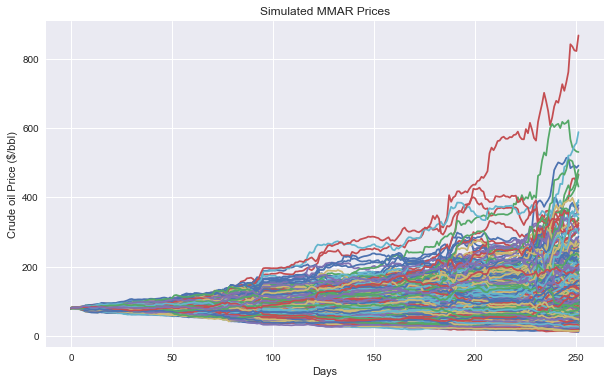

In [131]:
plot_mmar_paths(prices_paths, 'Simulated MMAR Prices', 'Days', 'Crude oil Price ($/bbl)')

Examinate the mean returns of the simulation return and prices derived from the mean return

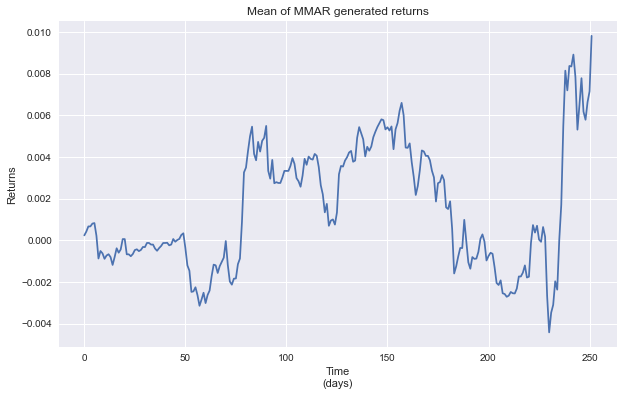

In [132]:
mean_return = np.mean(mmar_returns, axis=0)

plot_mmar_paths([mean_return], 'Mean of MMAR generated returns', 'Time\n(days)', 'Returns')

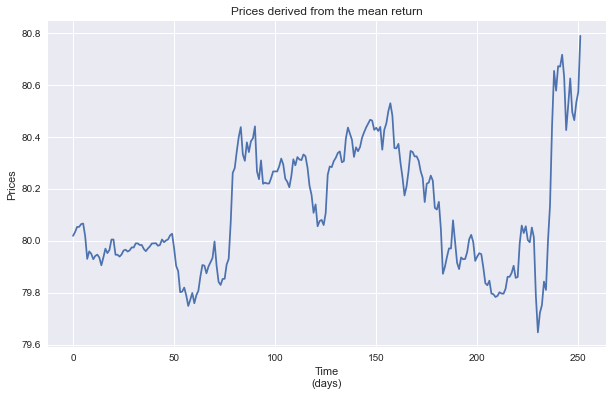

In [133]:
mean_prices = s0*np.exp(mean_return)

plot_mmar_paths([mean_prices], 'Prices derived from the mean return', 'Time\n(days)', 'Prices')

#### 15. Calculate the instinct value of options

In [134]:
s0 = 80  # Starting price
r = 0.05
T = 1
strike_p = 80  # Strike price

In [135]:
print("Call option price: ", option_pricer(prices_paths, strike_p, r, T, option_type='call'))
print("Put option price: ", option_pricer(prices_paths, strike_p, r, T, option_type='put'))

Call option price:  31.96239512062795
Put option price:  13.347950440506287


We may observed that from the simulated prices, there could be some huge vally based on the simulation that could be happened but with less possibility. We can get rid from those prices_paths for more realisetic but less purdence option pricing by paths cutting or values replacing

In [136]:
def price_options_for_strikes(paths, center=80, step=5, num_strikes=5, r=0.05, T=1):
    """
    """

    option_prices = {}

    # Calculate prices for many strikes
    for i in range(1, num_strikes + 1):
        strike = center - i * step
        option_prices[strike] = option_pricer(paths, strike, r, T, option_type='put')

    # Calculate prices for strikes at and above the center
    for i in range(num_strikes + 1):
        strike = center + i * step
        option_prices[strike] = option_pricer(paths, strike, r, T, option_type='call')

    return option_prices

prices = price_options_for_strikes(prices_paths, center=80, step=5, num_strikes=10, r=r, T=T)
for strike, price in prices.items():
    print(f"Strike {strike}: Price {price:.3f}")

Strike 75: Price 11.094
Strike 70: Price 9.032
Strike 65: Price 7.185
Strike 60: Price 5.544
Strike 55: Price 4.108
Strike 50: Price 2.919
Strike 45: Price 1.940
Strike 40: Price 1.235
Strike 35: Price 0.717
Strike 30: Price 0.361
Strike 80: Price 31.962
Strike 85: Price 29.658
Strike 90: Price 27.524
Strike 95: Price 25.569
Strike 100: Price 23.789
Strike 105: Price 22.162
Strike 110: Price 20.640
Strike 115: Price 19.236
Strike 120: Price 17.934
Strike 125: Price 16.742
Strike 130: Price 15.622


# Conclusion

The MMAR and the fractal theories applied to finance are extremely sophisticated and are more realistic representations of the characteristics of asset prices. However, given the model's burdensome methodology for estimation of parameters and sparse literature and documention, the adoption of the theory has lagged its potential. In this paper, we have found that from a theoretical perspective, the MMAR is a much more elegant way of describing asset prices and hence to model instruments derived of these assets of interest. However, from a pratictioner's perspective, the ease of Black and Scholes for option calculation is an extremely convenient feature. 
With some parameter calibration, we were able to devise a model capable of approximating market prices. This model could be expanded and improved and ultimately be used as a tool to price options that are not vanilla, listed options on the exchange, i.e exotic options priced by broker dealers and market markets. This is ultimately what a model similar to the ones we derived are useful for because listed options have prices that are transparent and easy to access. 
We also learned that another factor to consider when using more sophisticated models like Multifractal Models to derive option prices is the run time of the pricer. A simulation of 1000 paths of a Multifractal Model took us around 40 seconds while an FBM simulation with the same number of paths took around 5-10 seconds. Longer pricing times should also be a deterrent to use MMAR models to price vanilla, listed options. In the realm of exotic derivatives however, where pricing time is not an issue and the more realistic representation of stochastic process is something desirable, we believe MMAR models are very useful and should be in fact implemented.
In terms of modelling the parameters as per the original paper, we found that the methodology described is not of trivial implementation. We faced several issues when devising partition fuctions and the multifractal spectrum for example. We had trouble deriving realistic option prices following the original MMAR implementation. We were not able to find any implementation of the MMAR or Multifractal parameter estimation in python nor in any other open-sourced language.
In summary, we believe that as computational power increases, the usage of multifractal models should increase. There is certainly is a need for more research in the space, particularly for modelling and pricing of exotic derivatives. One interesting area of future development should be use of machine learning to derive the optimal multiplicative cascade function for a particular time series, as well as the calculation of the fractal parameters from a historical timeseries. 